In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import logging

import uuid

# naming conventions
# module_name, package_name, method_name, function_name, global_var_name, instance_var_name
# function_parameter_name, local_var_name
# ClassName, ExceptionName, CLASS_CONSTANT_NAME, GLOBAL_CONSTANT_NAME

In [11]:
logging.basicConfig(filename='growth_curves01.log',  level=logging.DEBUG)
#logging.debug  logging.info  logging.warning  logging.error

excel_data_filename = "../example_data/FCIC01.xlsx"

settings = {
    "SheetSummary" : 0, # summary sheet
    "ColumnSummarySheetName" : 0, # the summary sheet index
    "BioScreen C microtiter plate reader": "biomass (OD600)", # type to parse
    "ColumnTime" : 0 # which column has the time
}
df = pd.read_excel(excel_data_filename, sheet_name=settings["SheetSummary"])

tabs = pd.ExcelFile(excel_data_filename).sheet_names

logging.info(df.head())

logging.info(df.keys)

logging.info(tabs)
logging.info(len(tabs))

print(df.shape)

(138, 7)


In [12]:
def get_average_values_for_sheet(excel_data_file, sheet_to_process):

    """
    Method to convert a sheet into data chunks for downstream processing
    
    Arguments:
        excel_data_file: excel file to process
            
        sheet_to_process: excel sheet to process
        
    Returns:
        all_data: all data
        group: the groups
        header_groups: the header groups
        top_row: the top row
        df_averages_only: averages (grouped by header row entries)
        df_std_only: standard deviation (grouped by header row entries)
        
    Raises:
        ValueError: # implemented later
    
    """
    df_small_scale = pd.read_excel(excel_data_file, sheet_name=sheet_to_process)
    
    df_averages_only = pd.DataFrame()
    df_std_only = pd.DataFrame()
    
    df_averages_only["time"] = df_small_scale.iloc[:, 0]
    df_std_only["time"] = df_small_scale.iloc[:, 0]
    
    #print(df_small_scale.shape)
    header_groups = {}
    tmp_error = ""
    tmp_process_header = 0
    top_row = df_small_scale.columns.values.tolist()
    
    for i in range(1, len(top_row)):

        if(str(top_row[i]).find("+") > -1):
            # some entries follow the int+int+int pattern (mixture of compounds)
            tmp_e = ""
            tmp_process_header += 1
            if str(top_row[i]).find(".") > -1:
                tmp_array = str(top_row[i]).split(".")
                tmp_e = '.'.join(tmp_array[:-1])
            else:
                tmp_e = str(top_row[i])

            if tmp_e in header_groups:
                header_groups[tmp_e] += [i]
            else:
                # new element
                header_groups[tmp_e] = []
                header_groups[tmp_e] += [i]
        else:
            try:
                # one compound
                if str(top_row[i]).find(".") > -1:
                    tmp_array = str(top_row[i]).split(".")
                    tmp_e = '.'.join(tmp_array[:-1])
                else:
                    tmp_e = str(top_row[i])    
                temp_int = int(float(tmp_e))
                if str(temp_int) in header_groups:
                    # add
                    header_groups[str(temp_int)] += [i]
                else:
                    # new element
                    header_groups[str(temp_int)] = []
                    header_groups[str(temp_int)] += [i]
            except:
                tmp_error += "error"
    
    
    
    # get data
    all_data = []
    tmp_column_name = ""
    group_dictionary = {}
    group_list = []
    group = ()

    for key in header_groups:
        tmp_array = header_groups[key]

        tmp_min_index = min(tmp_array)
        tmp_max_index = max(tmp_array)

        tmp_name_of_column = "avg_" + key
        
        #print(tmp_name_of_column)

        df_small_scale = df_small_scale.assign(avg_0=df_small_scale.iloc[:,tmp_min_index:tmp_max_index].mean(axis=1))
        df_small_scale.columns.values[df_small_scale.shape[1]-1] = tmp_name_of_column
        tmp_data = (df_small_scale.iloc[:, 0], df_small_scale[tmp_name_of_column])
        all_data.append(tmp_data)
        group_dictionary[key] = tmp_name_of_column
        group_list.append(tmp_name_of_column)
        
        df_averages_only[tmp_name_of_column] = df_small_scale[tmp_name_of_column]
        
        #tmp_std = df_small_scale.iloc[:,tmp_min_index:tmp_max_index].std(axis=1).to_numpy()
        
        df_std_only[tmp_name_of_column] = df_small_scale.iloc[:,tmp_min_index:tmp_max_index].std(axis=1)
        #df_std_only[tmp_name_of_column] = tmp_std
    
    # convert group_list to tuple
    group = tuple(group_list)
    
    #print("OK")
    
    return all_data, group, header_groups, top_row, df_averages_only, df_std_only

In [13]:
def plot_sheet(all_data = (), groups = (), title="title", fig_width=10.0, fig_height = 4.0, symbol_size=1.8):
    """
    Plotting sheet (grouped)
    
    Arguments:
        all_data: all data from excel sheet
        groups: groups
        title: graph title
        fig_width: figure width
        fig_height: figure height
        symbol_size: size of symbol
    
    """
    fig = plt.figure()
    fig.set_figwidth(fig_width)
    fig.set_figheight(fig_height)
    ax = fig.add_subplot(1, 1, 1)

    #for data, color, group in zip(all_data, colors, groups):

    for data,  group in zip(all_data,  groups):

        
        x, y = data
        ax.scatter(x, y, alpha=0.8, edgecolors='none', s=symbol_size, label=group) #c=color, 

    plt.title(title)
    plt.legend(loc=4)

    plt.show()
    
    #print("OK")

707037e8-1072-4298-a8cc-eb44d83ab9a3
       time   avg_750   avg_500   avg_250   avg_100    avg_50     avg_0
0  0.001111  0.003464  0.005292  0.003512  0.002517  0.006807  0.005292
1  0.078056  0.002082  0.003215  0.001000  0.001155  0.004041  0.005568
2  0.327222  0.007000  0.001155  0.001528  0.001155  0.002517  0.007638
3  0.576389  0.002082  0.002887  0.002082  0.000577  0.002000  0.007550
4  0.826389  0.003215  0.001528  0.002082  0.000577  0.002000  0.007638


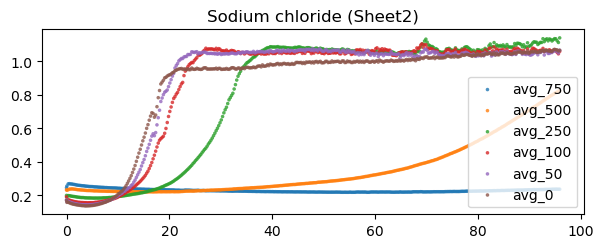

8bba3a3c-907d-4d0c-ab8b-984f7bf33dc0
       time       avg_375   avg_250   avg_125    avg_50    avg_25     avg_0
0  0.001111  2.081666e-03  0.003215  0.003215  0.002517  0.003786  0.005292
1  0.078056  3.399350e-17  0.004359  0.000577  0.000577  0.001732  0.005568
2  0.327222  2.645751e-03  0.003464  0.002309  0.001000  0.001155  0.007638
3  0.576389  2.000000e-03  0.005508  0.002646  0.000577  0.000577  0.007550
4  0.826389  3.511885e-03  0.006557  0.001155  0.001155  0.000577  0.007638


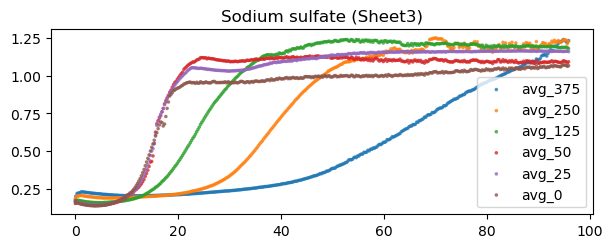

853315bc-bed6-43b9-941d-d1852e0b255b
       time   avg_750   avg_500   avg_250   avg_100    avg_50     avg_0
0  0.001389  0.005196  0.002887  0.003512  0.001155  0.001732  0.003848
1  0.036389  0.004041  0.002309  0.002082  0.001528  0.001528  0.002215
2  0.268889  0.004509  0.002000  0.001528  0.001000  0.001155  0.001676
3  0.517778  0.009539  0.001155  0.000577  0.000577  0.001732  0.001676
4  0.766944  0.009452  0.001000  0.001155  0.001000  0.001155  0.001618


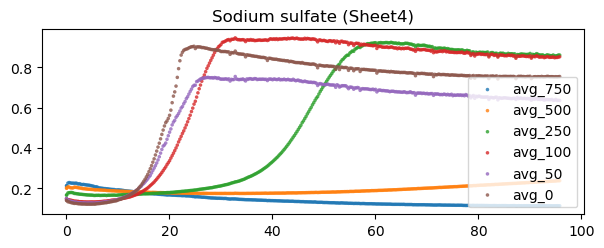

551c1fac-bb1f-4ec2-a08a-89c4de084c9e
       time   avg_750   avg_500   avg_250   avg_100    avg_50     avg_0
0  0.001111  0.004726  0.001000  0.008083  0.002517  0.003055  0.005292
1  0.078056  0.003055  0.003055  0.006506  0.002309  0.004509  0.005568
2  0.327222  0.000577  0.002000  0.003512  0.001000  0.003055  0.007638
3  0.576389  0.000577  0.003606  0.004041  0.000577  0.003055  0.007550
4  0.826389  0.003606  0.002887  0.002646  0.000577  0.003215  0.007638


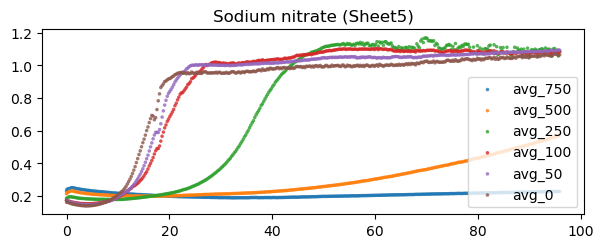

8d7475ef-4d6e-4d4f-851a-8d0de4ea0cf8
       time   avg_750   avg_500   avg_250   avg_100    avg_50     avg_0
0  0.001111  0.008083  0.008963  0.004509  0.005686  0.009074  0.005292
1  0.078056  0.002646  0.005774  0.002517  0.003512  0.004359  0.005568
2  0.327222  0.003786  0.005508  0.003606  0.002646  0.001732  0.007638
3  0.576389  0.006658  0.007550  0.003606  0.002646  0.001528  0.007550
4  0.826389  0.007024  0.007095  0.003055  0.002082  0.001528  0.007638


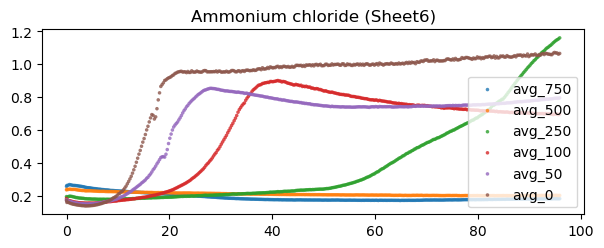

aa744b22-f1d4-4ca9-94f3-cbaccc5b126c
       time   avg_750   avg_500   avg_250   avg_100    avg_50     avg_0
0  0.001111  0.005508  0.002082  0.006506  0.002646  0.010440  0.009866
1  0.078056  0.001732  0.003512  0.004163  0.002309  0.003215  0.006245
2  0.327222  0.001732  0.006028  0.004726  0.001528  0.003606  0.002082
3  0.576389  0.002517  0.005033  0.005132  0.002887  0.002517  0.001155
4  0.826389  0.003055  0.007000  0.002517  0.003215  0.003055  0.001528


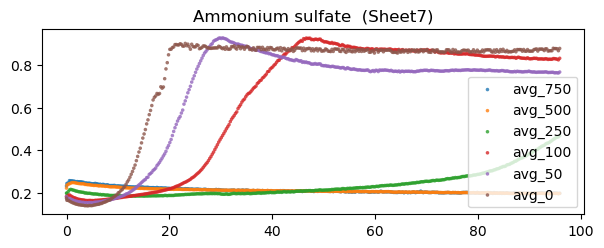

e24354bb-d5d7-4e79-8f36-bb53e8e29198
       time   avg_750   avg_500   avg_375   avg_250   avg_125     avg_0
0  0.001111  0.005196  0.004000  0.002309  0.001732  0.001528  0.009866
1  0.078056  0.001528  0.002517  0.002517  0.002646  0.001732  0.006245
2  0.327222  0.004933  0.004933  0.003055  0.001528  0.002517  0.002082
3  0.576389  0.005196  0.003215  0.002517  0.001528  0.002082  0.001155
4  0.826389  0.002082  0.003512  0.003215  0.001000  0.002000  0.001528


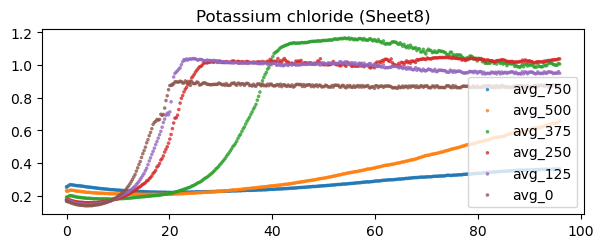

9f55d3b6-a069-4bbd-ba53-a2c7bdf09531
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001389  0.003215  0.003000  0.002000  0.010066  0.001528  0.003848
1  0.036389  0.003512  0.003606  0.003512  0.010000  0.001528  0.002215
2  0.268889  0.003786  0.004359  0.002517  0.005859  0.001155  0.001676
3  0.517778  0.001528  0.003786  0.003055  0.006083  0.000577  0.001676
4  0.766944  0.003055  0.005132  0.002309  0.007000  0.001155  0.001618


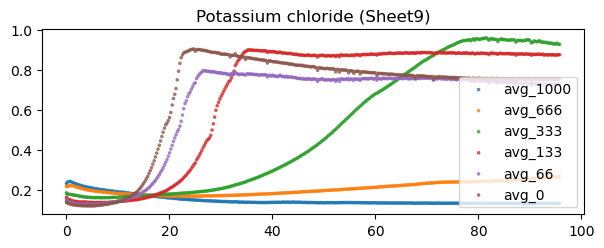

f5df3456-b0c6-47aa-9273-3203e915cf38
       time   avg_750   avg_500   avg_250   avg_100    avg_50     avg_0
0  0.001111  0.008386  0.004163  0.002082  0.003606  0.002082  0.009866
1  0.078056  0.002082  0.003055  0.002646  0.004933  0.001528  0.006245
2  0.327222  0.002309  0.003786  0.003000  0.004041  0.001528  0.002082
3  0.576389  0.004041  0.004041  0.001732  0.004359  0.001528  0.001155
4  0.826389  0.003512  0.003786  0.002082  0.004359  0.001155  0.001528


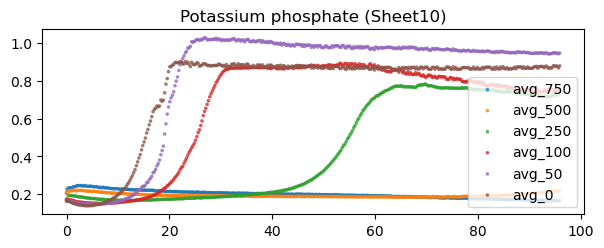

4dbfe003-68e6-41d1-82ec-817057c83da4
       time   avg_250   avg_167    avg_83    avg_33    avg_17     avg_0
0  0.001389  0.004509  0.005508  0.002646  0.009539  0.002887  0.008021
1  0.119722  0.000577  0.000577  0.003055  0.005568  0.000577  0.003055
2  0.369444  0.003512  0.000000  0.000000  0.002887  0.000000  0.002646
3  0.619444  0.001528  0.000577  0.000000  0.002309  0.000000  0.002517
4  0.869167  0.001000  0.000577  0.000000  0.002309  0.000000  0.002000


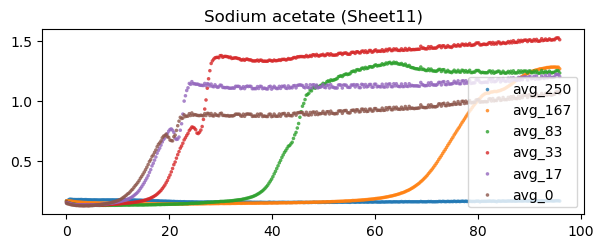

9724e83c-9785-4752-88ce-b5d2af0e1900
       time   avg_250   avg_167    avg_83    avg_33    avg_17     avg_0
0  0.001389  0.003606  0.001155  0.005196  0.007095  0.005196  0.008021
1  0.119722  0.002646  0.001732  0.004041  0.001528  0.001528  0.003055
2  0.369444  0.004509  0.001528  0.002082  0.002082  0.001155  0.002646
3  0.619444  0.001528  0.000577  0.002000  0.002000  0.001155  0.002517
4  0.869167  0.002517  0.000577  0.002082  0.002000  0.001000  0.002000


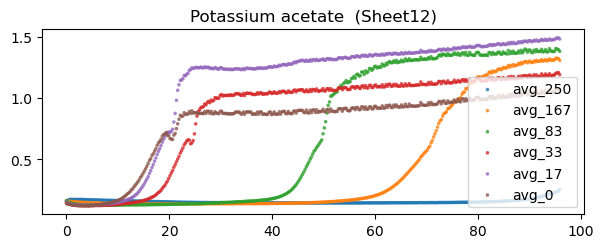

18d17ec1-af8c-44d7-b512-d33d37edaeb3
       time   avg_250   avg_167    avg_83    avg_33    avg_17     avg_0
0  0.001389  0.004509  0.006028  0.006083  0.010583  0.004933  0.008021
1  0.119722  0.000577  0.004359  0.001528  0.003606  0.003512  0.003055
2  0.369444  0.000577  0.003055  0.002082  0.002082  0.001528  0.002646
3  0.619444  0.000577  0.002887  0.001155  0.002082  0.002000  0.002517
4  0.869167  0.000577  0.002309  0.001732  0.002082  0.001732  0.002000


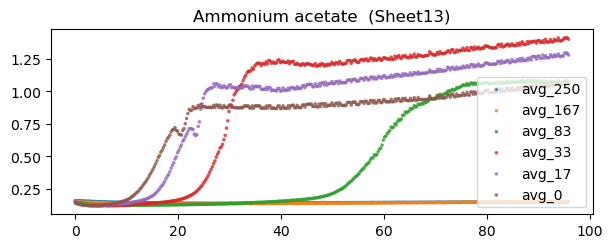

4ee77f3b-36ec-4f29-8900-1c84fb5e6ea5
       time   avg_250   avg_167    avg_83    avg_33    avg_17     avg_0
0  0.001389  0.006000  0.002646  0.003055  0.010693  0.001732  0.008021
1  0.119722  0.004041  0.001528  0.001528  0.006110  0.001528  0.003055
2  0.369444  0.003215  0.002000  0.002887  0.007024  0.001528  0.002646
3  0.619444  0.003215  0.003215  0.003786  0.006557  0.001528  0.002517
4  0.869167  0.002517  0.002082  0.002646  0.004583  0.001528  0.002000


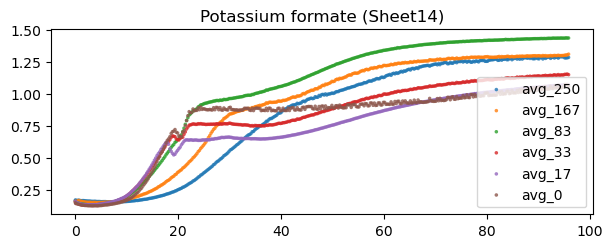

a7ac943d-74b0-4382-a834-6b0ee2e877a4
       time  avg_1000   avg_666   avg_500   avg_333   avg_133     avg_0
0  0.001111  0.000577  0.007506  0.001528  0.004509  0.003512  0.008194
1  0.133889  0.003215  0.004509  0.004163  0.003215  0.003786  0.011045
2  0.382778  0.003786  0.003606  0.004726  0.001528  0.003512  0.011458
3  0.631944  0.003055  0.001732  0.003606  0.001000  0.003606  0.011022
4  0.881944  0.004000  0.001528  0.005292  0.000577  0.004619  0.013140


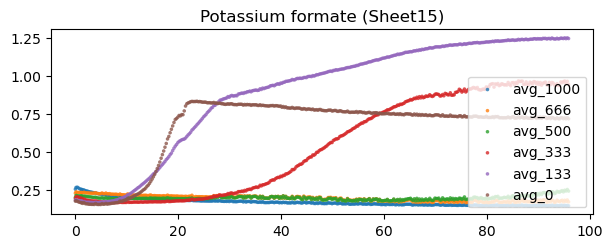

a0c41b95-db1a-4c3d-94fe-d138b1828cfd
       time  avg_1000   avg_666   avg_500   avg_333   avg_133     avg_0
0  0.001111  0.000577  0.007506  0.001528  0.004509  0.003512  0.008194
1  0.133889  0.003215  0.004509  0.004163  0.003215  0.003786  0.011045
2  0.382778  0.003786  0.003606  0.004726  0.001528  0.003512  0.011458
3  0.631944  0.003055  0.001732  0.003606  0.001000  0.003606  0.011022
4  0.881944  0.004000  0.001528  0.005292  0.000577  0.004619  0.013140


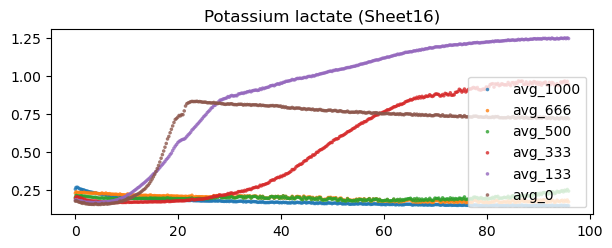

05140369-330e-4fc4-8ed8-2ced00944db8
       time  avg_1000   avg_666   avg_500   avg_333   avg_133     avg_0
0  0.001111  0.003055  0.004509  0.002309  0.004163  0.005508  0.008194
1  0.133889  0.003512  0.006658  0.003000  0.001155  0.006658  0.011045
2  0.382778  0.001155  0.004726  0.003512  0.001155  0.006110  0.011458
3  0.631944  0.002082  0.005132  0.004000  0.001528  0.005568  0.011022
4  0.881944  0.002082  0.006110  0.002646  0.001528  0.005686  0.013140


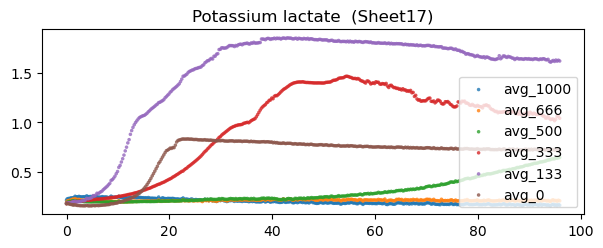

de7bbff5-fa05-4ef8-a755-d8d9a6dd2022
       time       avg_250   avg_167        avg_83        avg_33    avg_17  \
0  0.001389  2.000000e-03  0.004509  4.509250e-03  1.527525e-03  0.003786   
1  0.119722  1.000000e-03  0.002517  3.399350e-17  1.000000e-03  0.002517   
2  0.369444  3.399350e-17  0.001528  1.000000e-03  5.773503e-04  0.003055   
3  0.619444  1.527525e-03  0.001732  1.527525e-03  3.399350e-17  0.001528   
4  0.869167  1.154701e-03  0.002000  5.773503e-04  3.399350e-17  0.002000   

      avg_0  
0  0.008083  
1  0.003215  
2  0.002517  
3  0.001000  
4  0.001155  


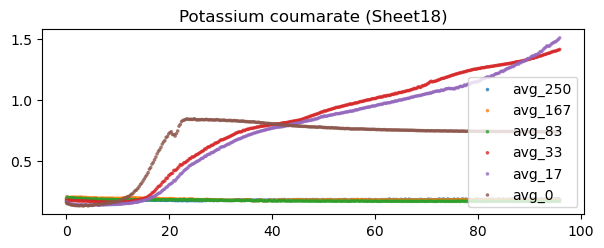

923edd9c-8859-436e-bbb0-18cdf60176fe
       time    avg_90    avg_75    avg_60    avg_30    avg_12     avg_0
0  0.001111  0.006028  0.008963  0.003606  0.010392  0.004509  0.008194
1  0.133889  0.004163  0.001528  0.003512  0.012897  0.003512  0.011045
2  0.382778  0.005686  0.002082  0.004041  0.019502  0.004041  0.011458
3  0.631944  0.004359  0.002517  0.003512  0.018520  0.004619  0.011022
4  0.881944  0.004359  0.002646  0.003606  0.021517  0.004041  0.013140


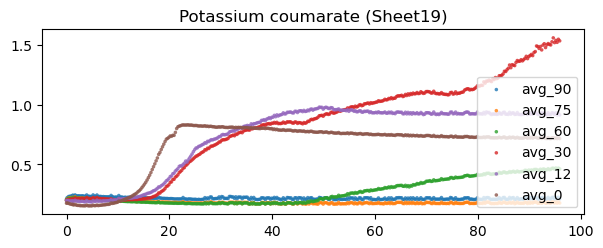

1ad87b42-2f82-47a0-9f9d-4ef5858a43e6
       time    avg_83    avg_65    avg_50    avg_33    avg_11     avg_0
0  0.001389  0.000577  0.001528  0.003055  0.005686  0.001732  0.003773
1  0.251667  0.004163  0.001528  0.001732  0.002517  0.000000  0.002854
2  0.501667  0.002887  0.002646  0.001155  0.002309  0.000000  0.002690
3  0.751667  0.001732  0.001528  0.001155  0.002517  0.000000  0.002760
4  1.001389  0.002000  0.001528  0.001000  0.003000  0.000000  0.002690


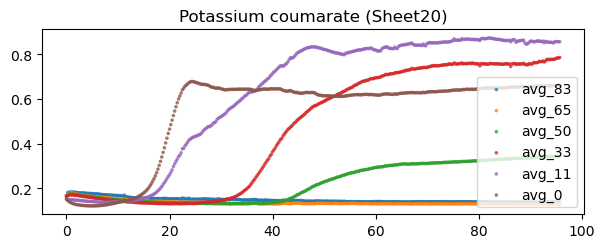

5e0c3546-9cb5-468b-9247-8d2b9d9cfde4
       time    avg_65    avg_43    avg_22     avg_9     avg_4     avg_0
0  0.001389  0.001000  0.001528  0.005132  0.008622  0.010214  0.008083
1  0.119722  0.001000  0.001732  0.002309  0.005774  0.003055  0.003215
2  0.369444  0.002082  0.002082  0.001732  0.004726  0.004359  0.002517
3  0.619444  0.002517  0.000000  0.002082  0.003464  0.003786  0.001000
4  0.869167  0.001528  0.000577  0.002082  0.003786  0.003512  0.001155


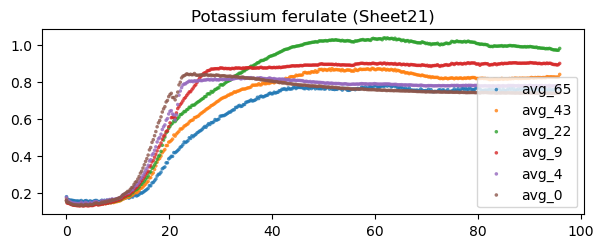

4a9ccc5c-bb2c-4270-b158-ce4af757793b
       time   avg_188   avg_166   avg_133   avg_100    avg_66     avg_0
0  0.001389  0.001155  0.003055  0.003215  0.001528  0.001528  0.003773
1  0.251667  0.003215  0.002517  0.003000  0.002000  0.001155  0.002854
2  0.501667  0.001528  0.002082  0.002082  0.003055  0.001528  0.002690
3  0.751667  0.001155  0.002000  0.002309  0.002517  0.002082  0.002760
4  1.001389  0.001155  0.002082  0.002082  0.003000  0.002517  0.002690


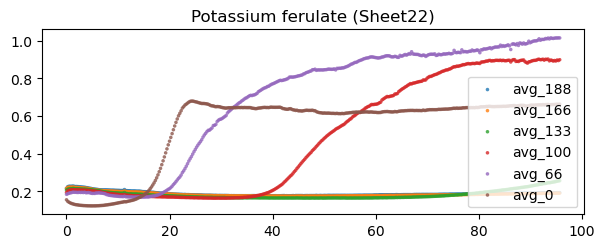

392eeccb-d766-4bdb-b1f3-4cc064af96a0
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.004583  0.002517  0.002082  0.005508  0.001528  0.004933
1  0.251389  0.003055  0.004000  0.001000  0.000577  0.001155  0.003512
2  0.501389  0.002082  0.004163  0.001000  0.000577  0.000577  0.001155
3  0.751389  0.001732  0.004041  0.000577  0.000577  0.000577  0.001528
4  1.001389  0.001155  0.004583  0.000577  0.000577  0.000577  0.001528


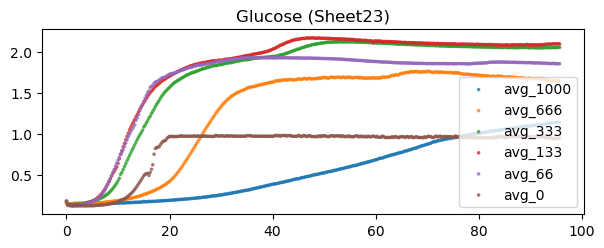

603514f0-340e-43da-8df6-ed5ae8028cb5
       time  avg_2500  avg_1666   avg_833   avg_333   avg_166     avg_0
0  0.001111  0.001000  0.001000  0.004041  0.001528  0.003215  0.003132
1  0.036111  0.001155  0.001528  0.004041  0.001528  0.001528  0.001633
2  0.285000  0.001528  0.002000  0.002517  0.001000  0.001155  0.001718
3  0.534722  0.001528  0.000577  0.001528  0.001000  0.001155  0.001397
4  0.784444  0.001000  0.001000  0.002000  0.000577  0.001155  0.000900


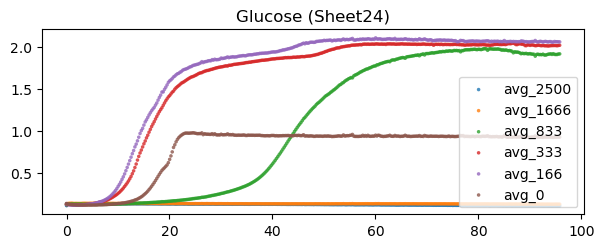

d9a9c181-1704-40d9-b6ea-fb08ae14359c
       time  avg_1600  avg_1333  avg_1066   avg_533   avg_213     avg_0
0  0.001111  0.003786  0.002646  0.003786  0.005000  0.002082  0.008194
1  0.133889  0.004000  0.002082  0.003215  0.003512  0.003055  0.011045
2  0.382778  0.001000  0.001528  0.005568  0.004041  0.002000  0.011458
3  0.631944  0.001528  0.001155  0.005568  0.002517  0.002517  0.011022
4  0.881944  0.002000  0.001000  0.004726  0.003786  0.001528  0.013140


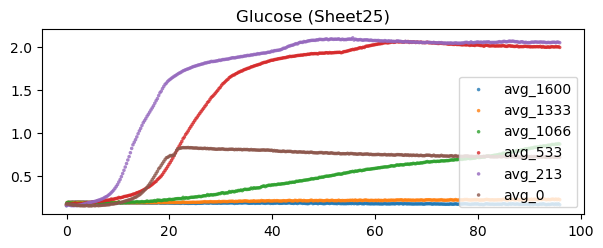

ba381b7f-e1d6-44d8-afca-462757bc6a50
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.002646  0.001732  0.002000  0.004359  0.003786  0.004933
1  0.251389  0.001732  0.000577  0.001528  0.001528  0.003055  0.003512
2  0.501389  0.001528  0.000577  0.000577  0.001000  0.002082  0.001155
3  0.751389  0.001528  0.000577  0.001155  0.001000  0.001528  0.001528
4  1.001389  0.002082  0.000577  0.001000  0.001155  0.001000  0.001528


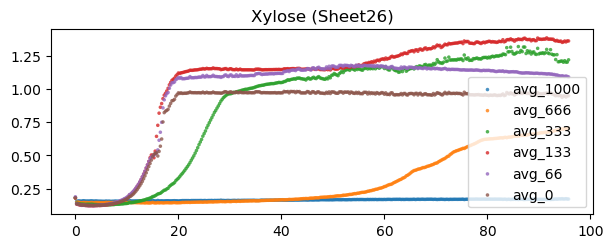

7194276f-113d-4402-8288-16ac01b32568
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.003512  0.004359  0.004041  0.000577  0.004163  0.004933
1  0.251389  0.001528  0.003215  0.002517  0.001528  0.002082  0.003512
2  0.501389  0.003000  0.001528  0.003000  0.001000  0.001528  0.001155
3  0.751389  0.003055  0.001155  0.002000  0.001155  0.001000  0.001528
4  1.001389  0.002646  0.001528  0.001528  0.000577  0.001155  0.001528


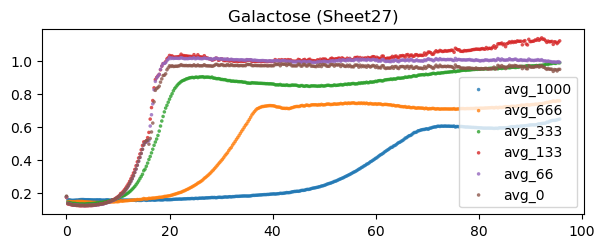

db865cb1-95cf-4c26-a981-1b8fcf328c25
       time  avg_2000  avg_1333   avg_666   avg_266   avg_133     avg_0
0  0.001111  0.003215  0.003055  0.001155  0.006658  0.001155  0.003132
1  0.036111  0.002082  0.002646  0.001000  0.004359  0.000577  0.001633
2  0.285000  0.001732  0.001000  0.000577  0.005292  0.000577  0.001718
3  0.534722  0.001732  0.001528  0.001000  0.004933  0.001732  0.001397
4  0.784444  0.002082  0.001528  0.001155  0.003786  0.001155  0.000900


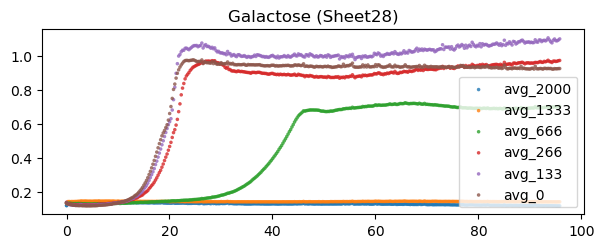

932b9b2b-e1ca-4988-9f51-eff93bacbb4c
       time  avg_1333   avg_888   avg_444   avg_177    avg_88     avg_0
0  0.001389  0.000577  0.001000  0.003215  0.002082  0.003464  0.003773
1  0.251667  0.002517  0.001528  0.002082  0.000577  0.002646  0.002854
2  0.501667  0.002082  0.001000  0.002887  0.000577  0.003786  0.002690
3  0.751667  0.003000  0.001155  0.001732  0.000577  0.003606  0.002760
4  1.001389  0.002082  0.001528  0.002082  0.000577  0.004163  0.002690


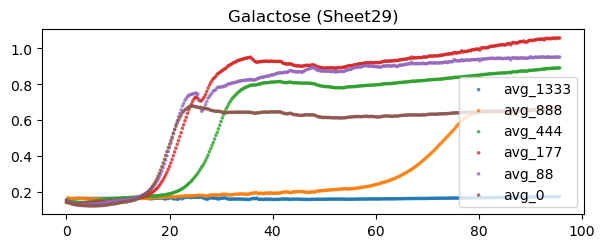

0e747291-6676-4ec7-a0cd-2ee0e4aab4b8
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.002082  0.001000  0.005132  0.001000  0.003606  0.004933
1  0.251389  0.001528  0.001528  0.004041  0.002309  0.001732  0.003512
2  0.501389  0.001528  0.002000  0.003464  0.002887  0.001528  0.001155
3  0.751389  0.002000  0.002517  0.003512  0.000577  0.002082  0.001528
4  1.001389  0.001528  0.001528  0.003000  0.000577  0.003000  0.001528


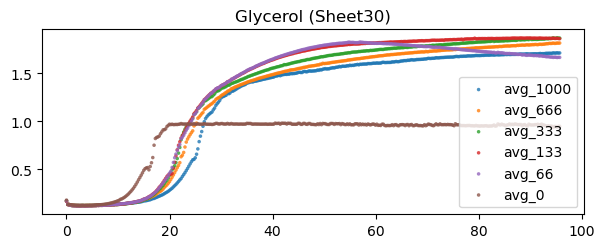

483f4e67-ce3f-4f69-86a9-de1a830afc1c
       time  avg_5000  avg_3333  avg_1666   avg_666   avg_333     avg_0
0  0.001111  0.001000  0.002082  0.001528  0.013429  0.001732  0.009090
1  0.036111  0.001000  0.002082  0.000577  0.014731  0.001155  0.005146
2  0.285000  0.001000  0.001155  0.001000  0.012166  0.001000  0.005678
3  0.534722  0.001000  0.001155  0.000577  0.012166  0.001000  0.005242
4  0.784444  0.001528  0.001528  0.000577  0.011269  0.001000  0.005669


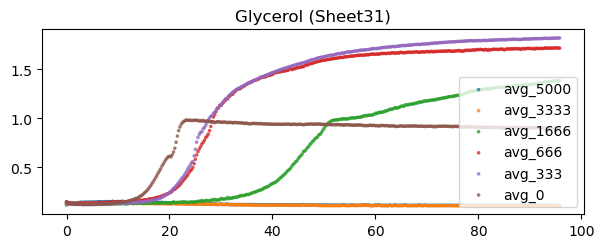

3c707c0d-3936-4857-b757-4cb477d2ccf6
       time  avg_2500  avg_2083  avg_1667   avg_833   avg_333     avg_0
0  0.001111  0.005859  0.002517  0.002517  0.003786  0.001732  0.008243
1  0.133889  0.003215  0.002517  0.001528  0.003055  0.001000  0.004337
2  0.382778  0.004000  0.002887  0.000577  0.002517  0.000000  0.003185
3  0.631944  0.004163  0.002887  0.000000  0.002646  0.001000  0.003101
4  0.881944  0.004583  0.002887  0.001000  0.002646  0.001155  0.003546


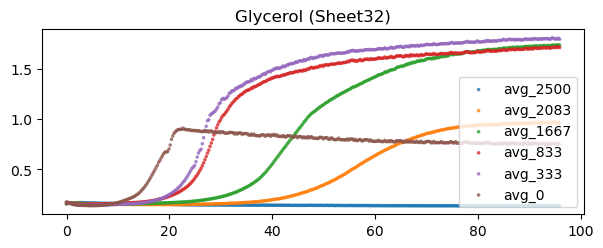

292d90c1-e344-4686-af6b-7962e7b89f10
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.001732  0.005292  0.003786  0.001528  0.002646  0.008544
1  0.251389  0.000577  0.002000  0.001155  0.001528  0.002000  0.003464
2  0.501389  0.000577  0.002646  0.000577  0.001732  0.001528  0.003055
3  0.751389  0.000577  0.002000  0.001000  0.001155  0.001528  0.003055
4  1.001389  0.001155  0.001155  0.000577  0.000577  0.001000  0.002309


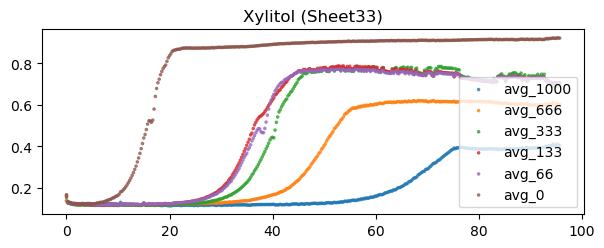

2eff6742-d0fc-4a95-9bbb-ce55d189d7f9
       time  avg_2750  avg_1833   avg_916   avg_366   avg_183     avg_0
0  0.001111  0.000577  0.001155  0.003786  0.002309  0.001155  0.009090
1  0.036111  0.000577  0.000577  0.003215  0.002646  0.001155  0.005146
2  0.285000  0.000577  0.000577  0.002517  0.001732  0.001000  0.005678
3  0.534722  0.000577  0.000577  0.002082  0.001528  0.000577  0.005242
4  0.784444  0.000000  0.000577  0.002082  0.001155  0.000577  0.005669


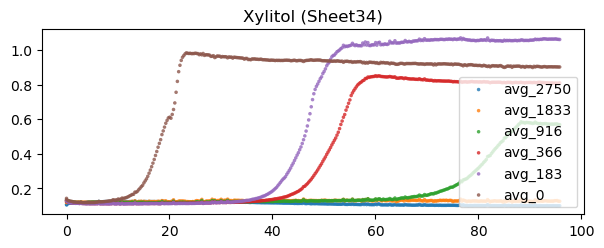

c53f2c44-573f-42d8-aa9e-05f170426316
       time  avg_1833  avg_1222   avg_917   avg_611   avg_244     avg_0
0  0.001111  0.001732  0.001528  0.001000  0.003786  0.002082  0.008243
1  0.133889  0.000577  0.002082  0.001528  0.001732  0.002309  0.004337
2  0.382778  0.001155  0.001732  0.002082  0.002082  0.002082  0.003185
3  0.631944  0.001528  0.001528  0.002309  0.001155  0.001528  0.003101
4  0.881944  0.002082  0.001732  0.002082  0.001528  0.002082  0.003546


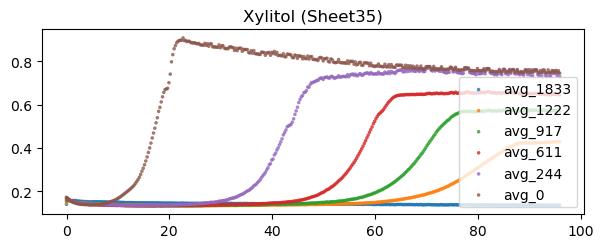

ccaf4606-0c50-4b10-b6ac-4b2b8d330587
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.003786  0.004163  0.006807  0.004509  0.002082  0.008544
1  0.251389  0.004933  0.003000  0.001000  0.002000  0.001000  0.003464
2  0.501389  0.003000  0.003055  0.002000  0.001000  0.000577  0.003055
3  0.751389  0.003512  0.002082  0.002517  0.000577  0.000577  0.003055
4  1.001389  0.003055  0.002309  0.002517  0.000577  0.001000  0.002309


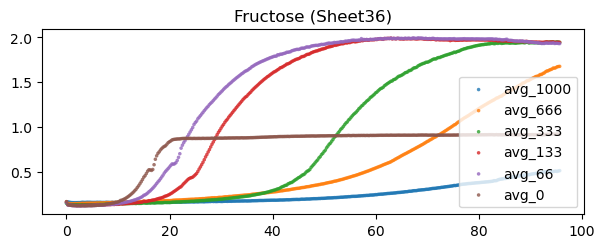

82cd3d99-855f-4101-ad0f-523ea0fd8e35
       time  avg_2000  avg_1333   avg_666   avg_266   avg_133     avg_0
0  0.001111  0.000577  0.003512  0.002309  0.000577  0.003786  0.009090
1  0.036111  0.000577  0.002646  0.001732  0.001000  0.002082  0.005146
2  0.285000  0.001155  0.002646  0.001000  0.000000  0.002000  0.005678
3  0.534722  0.000577  0.002646  0.001155  0.000577  0.002000  0.005242
4  0.784444  0.000577  0.002887  0.000577  0.000577  0.002517  0.005669


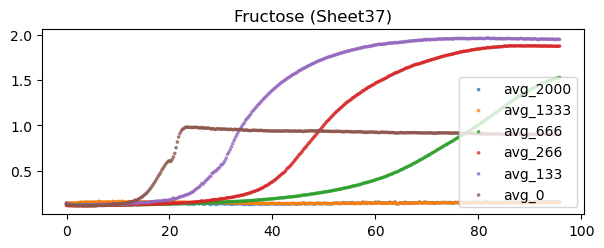

f7aacf0a-9b6c-440c-ab82-812598efa8a9
       time  avg_1000   avg_666   avg_333   avg_133    avg_66     avg_0
0  0.001667  0.002646  0.001732  0.001000  0.005132  0.006083  0.008544
1  0.251389  0.004163  0.002646  0.001000  0.002646  0.003215  0.003464
2  0.501389  0.004583  0.002517  0.001155  0.001528  0.003512  0.003055
3  0.751389  0.004726  0.002000  0.001155  0.001528  0.003000  0.003055
4  1.001389  0.004163  0.001528  0.001000  0.001155  0.002517  0.002309


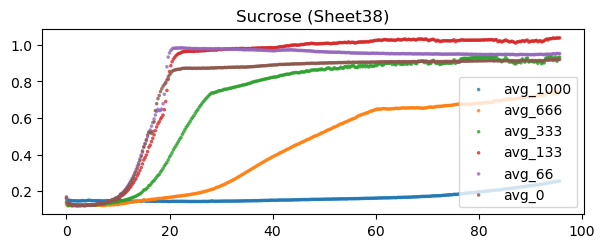

a35d77d9-1be6-4a13-9b55-807ba870d5ed
       time  avg_2000  avg_1333   avg_666   avg_266   avg_133     avg_0
0  0.001111  0.004933  0.002082  0.003464  0.024786  0.005686  0.009090
1  0.036111  0.002646  0.001155  0.002082  0.018358  0.003606  0.005146
2  0.285000  0.002646  0.000577  0.001528  0.017098  0.003786  0.005678
3  0.534722  0.003215  0.002309  0.001528  0.018583  0.003786  0.005242
4  0.784444  0.003215  0.002646  0.001528  0.019975  0.003786  0.005669


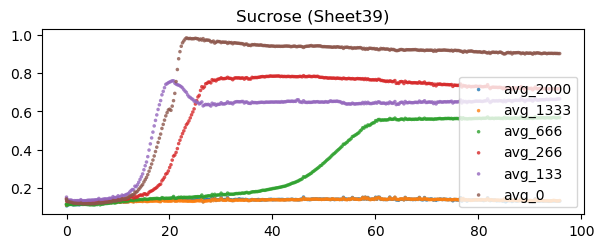

7c6cba85-d7d2-4d34-8ee6-ce281cba8f97
       time  avg_1250   avg_833   avg_416   avg_166    avg_83     avg_0
0  0.001389  0.002887  0.001528  0.000577  0.033501  0.002309  0.003773
1  0.251667  0.001155  0.001732  0.001000  0.030892  0.003055  0.002854
2  0.501667  0.000577  0.001732  0.001528  0.030892  0.003512  0.002690
3  0.751667  0.000577  0.002082  0.001000  0.029160  0.003055  0.002760
4  1.001389  0.000577  0.002082  0.001732  0.028006  0.002646  0.002690


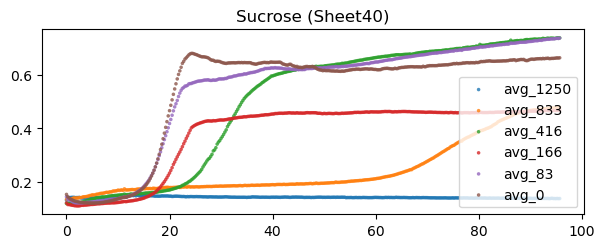

a5cb2e50-c5db-495b-ba22-a6820ddffab4
       time  avg_2000  avg_1333   avg_666   avg_266   avg_133     avg_0
0  0.001111  0.001000  0.001155  0.001000  0.000577  0.001528  0.003132
1  0.036111  0.001000  0.001000  0.001528  0.000577  0.001732  0.001633
2  0.285000  0.001155  0.002646  0.001000  0.000577  0.001155  0.001718
3  0.534722  0.000577  0.005132  0.001000  0.000577  0.001000  0.001397
4  0.784444  0.000577  0.005292  0.001000  0.000577  0.000577  0.000900


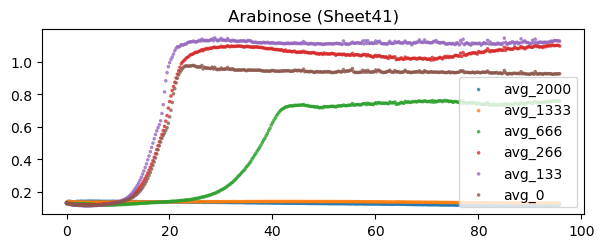

c8aa6a92-864b-457f-9ba0-87d039c62422
       time  avg_1400   avg_933   avg_466   avg_186    avg_93     avg_0
0  0.001389  0.003000  0.000577  0.001528  0.005508  0.000577  0.027233
1  0.251667  0.002646  0.001732  0.000577  0.002887  0.001732  0.026443
2  0.501667  0.002000  0.002309  0.001155  0.002309  0.002309  0.024750
3  0.751667  0.003215  0.002517  0.001155  0.002309  0.001732  0.023494
4  1.001389  0.003215  0.002000  0.000577  0.001528  0.001732  0.022284


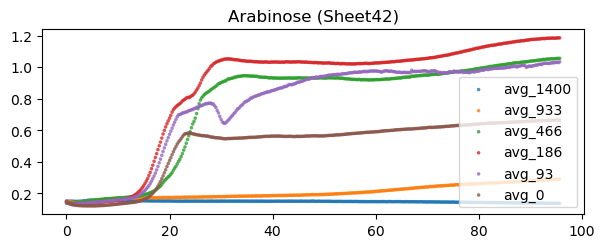

9eb0f289-09c9-47c1-9553-b6c05c875eba
       time   avg_500       avg_333   avg_166    avg_66    avg_33     avg_0
0  0.001389  0.004163  3.399350e-17  0.001000  0.001155  0.001000  0.003848
1  0.036389  0.004583  5.773503e-04  0.000577  0.000577  0.000577  0.002215
2  0.268889  0.005774  5.773503e-04  0.001000  0.000577  0.001000  0.001676
3  0.517778  0.003055  5.773503e-04  0.000577  0.000577  0.001000  0.001676
4  0.766944  0.001528  3.399350e-17  0.000000  0.001000  0.001155  0.001618


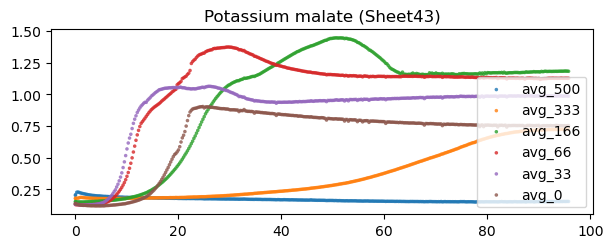

42


In [14]:
sheets_to_process = []
for index, row in df.iterrows():
    tmp_uuid = uuid.uuid4()
    if row[4] in settings:
        #print("process")
        print(tmp_uuid)
        sheets_to_process.append(row[0])
        tmp_all_data, tmp_group, tmp_header_groups, tmp_top_row, tmp_df_averages_only, df_std_only = get_average_values_for_sheet(excel_data_filename, row[0])

        #print(tmp_df_averages_only.head())
        print(df_std_only.head())
        #print(df_std_only[0][0][1])
        
        # plot
        plot_sheet(all_data=tmp_all_data, groups=tmp_group, title=row[1] + " (" + row[0] + ")", fig_width=7.0, fig_height = 2.4, symbol_size=6.5)
print(len(sheets_to_process))
